In [1]:
pip_list = !pip list
packages = ["dabl", "imblearn", "keras-tuner", "mysql-connector-python", "numpy", "pandas", "sklearn", "tensorflow"]
for package in packages:
    if not pip_list.grep(package):
        !pip3 install {package}

print("Package installations completed.")

Package installations completed.


In [2]:
import calendar
import datetime
import os
import random
import shutil
import warnings
from pickle import dump

import chardet
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
import requests
import scipy.stats as stat
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
from dabl import SimpleClassifier, SimpleRegressor, clean, plot
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from IPython.display import display
from keras_tuner.tuners import BayesianOptimization, Hyperband, RandomSearch
from mysql.connector import errorcode
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor,
                              VotingClassifier, VotingRegressor)
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import (SelectKBest, SelectPercentile,
                                       VarianceThreshold, chi2, f_classif,
                                       mutual_info_classif)
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (classification_report, mean_squared_error,
                             plot_confusion_matrix, plot_roc_curve, r2_score,
                             roc_auc_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedKFold, train_test_split)
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (FunctionTransformer, MinMaxScaler,
                                   OneHotEncoder, OrdinalEncoder,
                                   PolynomialFeatures, StandardScaler)
from sklearn.svm import SVC, SVR
from sklearn.tree import (DecisionTreeClassifier, DecisionTreeRegressor,
                          plot_tree)
from sklearn.utils import class_weight
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
set_config(display="diagram", print_changed_only=False)
pd.set_option("display.float_format", lambda f: "%.2f" % f)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.rc("axes", labelsize=12)
plt.rc("axes", titlesize=12)
plt.rc("font", size=10)
plt.rcParams["figure.figsize"] = [18, 7]
plt.style.use("dark_background")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())
print(os.system("cat /proc/cpuinfo | grep 'model name'"))
print(os.system("cat /proc/meminfo | grep 'MemTotal'"))
print(os.system("nvidia-smi"))

/opt/conda/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5754302360207224881
]
[]

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
0
MemTotal:       18433000 kB
0
32512


sh: 1: nvidia-smi: not found


In [3]:
import asyncio
import base64
import functools
import os
import time

import aiohttp
import nest_asyncio

nest_asyncio.apply()

df_final = pd.DataFrame()

(
    graph_api_headers,
    rest_api_headers,
    devops_api_headers,
    devops_pat_headers,
    ea_api_headers,
) = [""] * 5


def timer(func):
    if asyncio.iscoroutinefunction(func):

        @functools.wraps(func)
        async def wrapper(*args, **kwargs):
            start_time = time.time()
            await func(*args, **kwargs)
            print(f"total runtime for async func: {time.time() - start_time}")

        return wrapper
    else:

        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            start_time = time.time()
            func(*args, **kwargs)
            print(f"total runtime for sync func: {time.time() - start_time}")

        return wrapper


def get_api_headers_decorator(func):
    @functools.wraps(func)
    async def wrapper(session, *args, **kwargs):
        return {
            "Authorization": f"Basic {base64.b64encode(bytes(os.environ[args[0]], 'utf-8')).decode('utf-8')}"
            if "PAT" in args[0]
            else f"Bearer {os.environ[args[0]] if 'EA' in args[0] else await func(session, *args, **kwargs)}",
            "Content-Type": "application/json-patch+json"
            if "PAT" in args[0]
            else "application/json",
        }

    return wrapper


@get_api_headers_decorator
async def get_api_headers(session, *args, **kwargs):
    oauth2_headers = {"Content-Type": "application/x-www-form-urlencoded"}
    oauth2_body = {
        "client_id": os.environ[args[0]],
        "client_secret": os.environ[args[1]],
        "grant_type": "client_credentials",
        "scope" if "GRAPH" in args[0] else "resource": args[2],
    }
    async with session.post(
        url=args[3], headers=oauth2_headers, data=oauth2_body
    ) as resp:
        return (await resp.json())["access_token"]


@timer
async def main(params):
    global graph_api_headers, rest_api_headers, devops_api_headers, devops_pat_headers, ea_api_headers
    async with aiohttp.ClientSession() as session:
        (
            graph_api_headers,
            rest_api_headers,
            devops_api_headers,
            devops_pat_headers,
            ea_api_headers,
        ) = await asyncio.gather(
            *(get_api_headers(session, *param) for param in params)
        )


if __name__ == "__main__":
    params = [
        [
            "GRAPH_CLIENT_ID",
            "GRAPH_CLIENT_SECRET",
            "https://graph.microsoft.com/.default",
            f"https://login.microsoftonline.com/{os.environ['TENANT_ID']}/oauth2/v2.0/token",
        ],
        [
            "REST_CLIENT_ID",
            "REST_CLIENT_SECRET",
            "https://management.azure.com",
            f"https://login.microsoftonline.com/{os.environ['TENANT_ID']}/oauth2/token",
        ],
        [
            "DEVOPS_CLIENT_ID",
            "DEVOPS_CLIENT_SECRET",
            "https://management.azure.com",
            f"https://login.microsoftonline.com/{os.environ['TENANT_ID']}/oauth2/token",
        ],
        ["DEVOPS_PAT_TOKEN"],
        ["PRIMARY_EA_API_TOKEN"],
    ]
    asyncio.run(main(params))


def timer(func):
    if asyncio.iscoroutinefunction(func):

        @functools.wraps(func)
        async def wrapper(*args, **kwargs):
            start_time = time.time()
            await func(*args, **kwargs)
            print(f"total runtime for async func: {time.time() - start_time}")

        return wrapper
    else:

        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            start_time = time.time()
            func(*args, **kwargs)
            print(f"total runtime for sync func: {time.time() - start_time}")

        return wrapper


async def generate_bill(session, year, month, guid):
    try:
        async with session.get(
            url=f"https://management.azure.com/subscriptions/{guid}/providers/Microsoft.Consumption/usageDetails?metric=AmortizedCost&$filter=properties/usageStart+ge+'{year}-{month:02}-01'+AND+properties/usageEnd+le+'{year}-{month:02}-{calendar.monthrange(year, month)[1]:02}'&api-version=2019-04-01-preview",
            headers=rest_api_headers,
        ) as resp:
            return pd.DataFrame(
                row["properties"] for row in (await resp.json())["value"]
            )
    except Exception:
        print(f"Error: {year}-{month}")
        return pd.DataFrame()


@timer
async def main(years, guids):
    global df_final
    async with aiohttp.ClientSession() as session:
        df_final = pd.concat(
            iter(
                await asyncio.gather(
                    *(
                        generate_bill(session, year, month, guid)
                        for guid in guids
                        for year in years
                        for month in range(1, 13)
                    )
                )
            ),
            ignore_index=True,
        )
        print(df_final.shape)


if __name__ == "__main__":
    asyncio.run(
        main(
            years=range(2019, 2023),
            guids=[os.environ["SUBSCRIPTION_IDs"]],
        )
    )
    print(list(df_final["billingPeriodStartDate"].unique()))

display(df)

,date,year,month,cost,resourceLocation,consumedService,product
0,2019-01-01,2019,1,0.21,ausoutheast,Microsoft.Compute,Premium SSD Managed Disks - P4 - Disks - AU So...
1,2019-01-01,2019,1,0.74,ausoutheast,Microsoft.Compute,Standard HDD Managed Disks - S15 - LRS - Disks...
2,2019-01-01,2019,1,4.24,ausoutheast,Microsoft.Compute,Virtual Machines Dv2/DSv2 Series Windows - D1 ...
3,2019-01-01,2019,1,0.00,ausoutheast,Microsoft.Storage,Tables - Batch Write Operations
4,2019-01-01,2019,1,8.52,ausoutheast,Microsoft.Compute,Virtual Machines Dv2/DSv2 Series Windows - D2 ...
...,...,...,...,...,...,...,...
40995,2022-05-30,2022,5,6.54,AustraliaSouthEast,Microsoft.Compute,Virtual Machines Dv3/DSv3 Series - D4 v3/D4s v...
40996,2022-05-30,2022,5,0.00,AustraliaSouthEast,Microsoft.Compute,Premium SSD Managed Disks - LRS Snapshots - AU...
40997,2022-05-30,2022,5,0.35,AustraliaEast,Microsoft.Compute,Standard SSD Managed Disks - LRS - Disk Operat...
40998,2022-05-30,2022,5,0.00,AustraliaSouthEast,Microsoft.Compute,SQL Server Azure Hybrid Benefit - Standard Edi...


In [4]:
RANDOM_STATE = 11
SEARCH = ["hyperband", "random", "bayesian"][0]
EPOCHS = 500
MAX_TRIALS = 20
DUPLICATES = 0
SCALER = 1
CLASSIFICATION = 0

print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Duplicates Percentage: {df.duplicated().sum() / df.shape[0] * 100:.2f}%")
if DUPLICATES:
    print(f"Duplicates have been kept {df.shape}.")
else:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates have been removed {df.shape}.")
display(df.sample(3))
y_label = "cost"

-------------------------------------------------------
Current Shape: (41000, 7).
-------------------------------------------------------
Duplicates Percentage: 15.80%
Duplicates have been removed (34520, 7).


,date,year,month,cost,resourceLocation,consumedService,product
32280,2021-09-09,2021,9,1.39,AustraliaSouthEast,Microsoft.RecoveryServices,Backup - GRS Data Stored - AU Southeast
24500,2021-01-16,2021,1,0.01,AustraliaEast,Microsoft.Compute,Windows Server - 4 vCPU VM License
10653,2019-11-20,2019,11,0.76,ausoutheast,Microsoft.Compute,Standard HDD Managed Disks - S15 - LRS - Disks...


In [5]:
df.dropna(subset=[y_label], inplace=True)
print("-------------------------------------------------------")
print(f"Dropping null target values.")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"y Value Counts:\n{df[y_label].value_counts()}")

-------------------------------------------------------
Dropping null target values.
Current Shape: (34520, 7).
-------------------------------------------------------
y Value Counts:
0.00    1653
0.38      95
5.17      87
0.27      73
0.26      66
        ... 
0.00       1
0.00       1
0.00       1
0.00       1
0.02       1
Name: cost, Length: 18209, dtype: int64


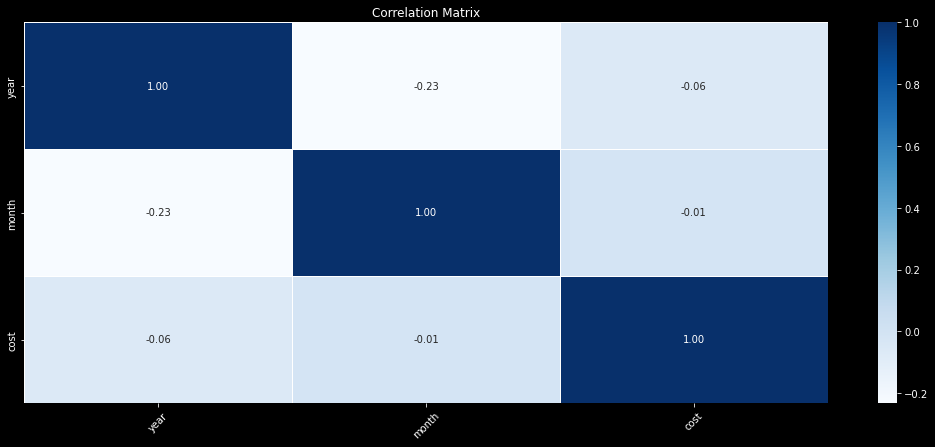

In [6]:
sns.heatmap(df.corr(), cmap="Blues", fmt=".2f", annot=True, linewidths=1)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.show()

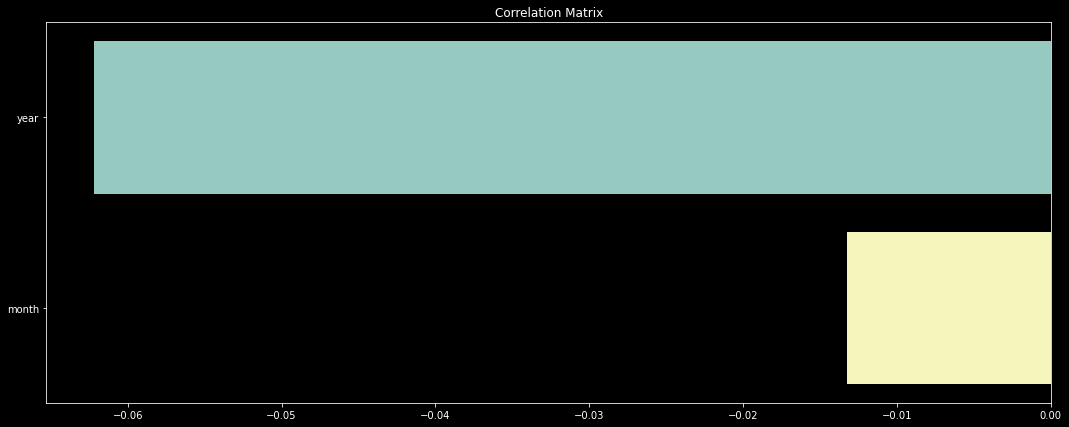

In [7]:
corr_matrix = df.corr()[y_label].sort_values().drop(y_label)
sns.barplot(x=corr_matrix.values, y=corr_matrix.index).set_title("Correlation Matrix")
plt.show()

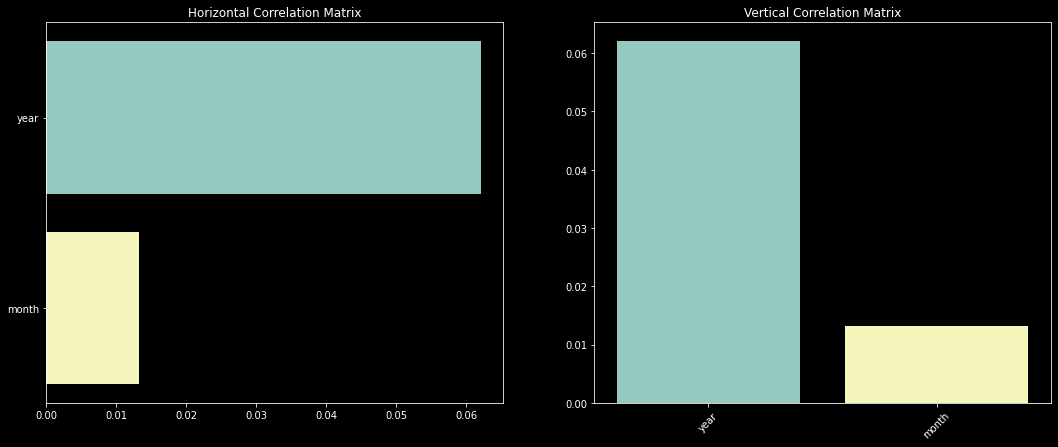

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2)
corr_matrix = df.corr()[y_label].abs().sort_values(ascending=False).drop(y_label)
sns.barplot(x=corr_matrix.values, y=corr_matrix.index, ax=ax[0]).set_title("Horizontal Correlation Matrix")
sns.barplot(x=corr_matrix.index, y=corr_matrix.values, ax=ax[1]).set_title("Vertical Correlation Matrix")
plt.xticks(rotation=45)
plt.show()

In [9]:
def correlation(X, threshold):
    col_corr = set()
    df_corr = X.corr().abs()
    for i, _ in enumerate(df_corr.columns):
        for j in range(i):
            if (df_corr.iloc[i, j] >= threshold) and (
                df_corr.columns[j] not in col_corr
            ):
                col_corr.add(df_corr.columns[i])
    return col_corr

col_drop = correlation(df.drop(y_label, axis=1), 0.85)
df.drop(col_drop, inplace=True, axis=1)
print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Highly correlated cols have been removed: {len(col_drop)}.")
print(f"Highly correlated cols: {col_drop}.")

-------------------------------------------------------
Current Shape: (34520, 7).
-------------------------------------------------------
Highly correlated cols have been removed: 0.
Highly correlated cols: set().


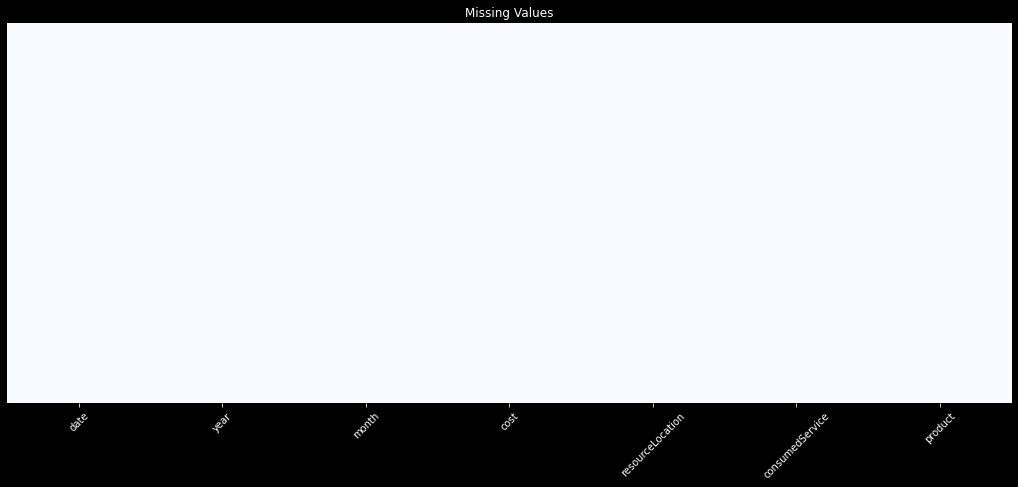

In [10]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="Blues")
plt.title("Missing Values")
plt.xticks(rotation=45)
plt.show()

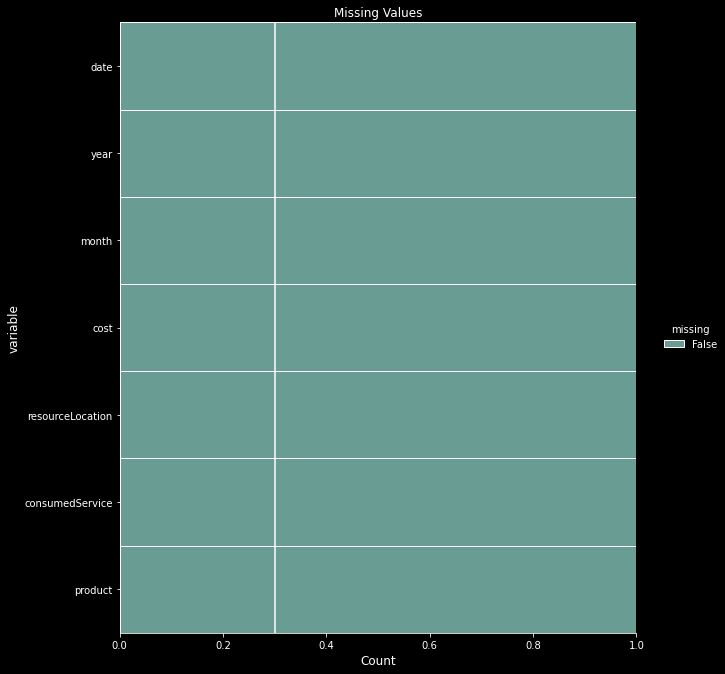

In [11]:
sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=9.25,
)
plt.axvline(0.3, color="white")
plt.title("Missing Values")
plt.show()

In [12]:
"""
%a: Weekday, abbreviated: Mon, Tues, Sat
%A: Weekday, full name: Monday, Tuesday, Saturday
%w: Weekday, decimal. 0=Sunday: 1, 2, 6
%d: Day of month, zero-padded: 01, 02, 21
%b: Month, abbreviated: Jan, Feb, Sep
%B: Month, full name: January, February, September
%m: Month number, zero-padded: 01, 02, 09
%y: Year, without century, zero-padded: 02, 95, 99
%Y: Year, with century: 1990, 2020
%H: Hour (24 hour), zero padded: 01, 22
%I: Hour (12 hour) zero padded: 01, 12
%p: AM or PM: AM, PM
%M: Minute, zero-padded: 01, 02, 43
%S: Second, zero padded: 01, 32, 59
%f: Microsecond, zero-padded: 000001, 000342, 999999
%z: UTC offset ±HHMM[SS[.ffffff]]: +0000, -1030, -3423.234
%Z: Time zone name: ITC, EST, CST
%j: Day of year, zero-padded: 001, 365, 023
%U: Week # of year, zero-padded. Sunday first day of week: 00, 01, 51
%W: Week # of year, zero-padded. Monday first day of week: 00, 02, 51
%c: Appropriate date and time: Monday Feb 01 21:30:00 1990
%x: Appropriate Date: 02/01/90
%X: Appropriate Time: 21:22:00
"""
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df["product"] = df["product"].str.lower()
df["product"] = df["product"].map(lambda p: "vm disk" if "disk" in p else "vm" if "series" in p else "storage account" if "blob" in p else "backup" if "backup" in p else "network" if "band" in p else "storage account" if "table" in p else "license" if "license" in p else "network" if "vpn" in p else "storage account" if "file" in p else "network" if "network" in p else "security" if "def" in p else "network" if "traffic" in p else "network" if "express" in p else "security" if "vault" in p else "sql" if "sql" in p else "network" if "ip" in p else "security" if "insight" in p else p)
df["consumedService"] = df["consumedService"].str.split(".").str.get(1).str.lower()
df["resourceLocation"] = df["resourceLocation"].map(lambda r: "AustraliaSouthEast" if r == "ausoutheast" else "AustraliaEast" if r == "aueast" else r)

In [13]:
col_cat_oe = []
preprocessor_cat_oe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OrdinalEncoder(categories=[["", ""]])),
)
col_cat = [col for col in df.columns if np.issubsctype(df[col].dtype, np.object0) and col != y_label]
col_num = [col for col in df.columns if np.issubsctype(df[col].dtype, np.number) and col != y_label]
col_cat_ohe = [col for col in col_cat if col not in col_cat_oe]
col_num_disc = [col for col in col_num if df[col].nunique() < 25]
col_num_cont = [col for col in col_num if col not in col_num_disc]

df_info = pd.DataFrame(
    {
        "column": [col for col in df.columns],
        "dtype": [f"{df[col].dtype}" for col in df.columns],
        "na": [f"{df[col].isna().sum()}" for col in df.columns],
        "na %": [f"{round(df[col].isna().sum() / df[col].shape[0] * 100)}%" for col in df.columns],
        "outliers": [f"{((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()}" if col in col_num else "n/a" for col in df.columns],
        "outliers %": [f"{round((((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()) / df[col].shape[0] * 100)}%" if col in col_num else "n/a" for col in df.columns],
        "kurtosis": [f"{df[col].kurtosis(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "skewness": [f"{df[col].skew(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "corr": [f"{round(df[col].corr(other=df[y_label]) * 100)}%" if col in col_num else "n/a" for col in df.columns],
        "nunique": [f"{df[col].nunique()}" for col in df.columns],
        "unique": [sorted(df[col].unique()) if col in col_num else df[col].unique() for col in df.columns],
    }
).sort_values(by="dtype", ascending=False)
display(df_info)
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"total na %: {df.isnull().sum().sum() / np.product(df.shape) * 100:.2f}%")
print("-------------------------------------------------------")
print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
print("-------------------------------------------------------")
print(f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_num_disc) + len(col_num_cont)}")

,column,dtype,na,na %,outliers,outliers %,kurtosis,skewness,corr,nunique,unique
4,resourceLocation,object,0,0%,n/a,n/a,n/a,n/a,n/a,4,"[AustraliaSouthEast, AustraliaEast, All Region..."
5,consumedService,object,0,0%,n/a,n/a,n/a,n/a,n/a,7,"[compute, storage, network, recoveryservices, ..."
6,product,object,0,0%,n/a,n/a,n/a,n/a,n/a,8,"[vm disk, vm, storage account, network, licens..."
1,year,int64,0,0%,0,0%,-1.09,0.22,-6%,4,"[2019, 2020, 2021, 2022]"
2,month,int64,0,0%,0,0%,-1.25,0.16,-1%,12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
3,cost,float64,0,0%,n/a,n/a,n/a,n/a,n/a,18209,"[0.214820243061854, 0.738145161290323, 4.24309..."
0,date,datetime64[ns],0,0%,n/a,n/a,n/a,n/a,n/a,1146,"[2019-01-01T00:00:00.000000000, 2019-01-02T00:..."


Current Shape: (34520, 7).
-------------------------------------------------------
total na %: 0.00%
-------------------------------------------------------
col_cat_oe (0): []
col_cat_ohe (3): ['resourceLocation', 'consumedService', 'product']
col_num_disc (2): ['year', 'month']
col_num_cont (0): []
-------------------------------------------------------
total cols for preprocessor: 5


In [14]:
for col in col_cat_ohe:
    sr_temp = df.groupby(col)[y_label].count() / df.shape[0]
    df_temp = sr_temp[sr_temp > 0.01].index
    df[col] = np.where(df[col].isin(df_temp), df[col], "-")

In [15]:
MAX_COLS = 100
for col in col_cat_ohe:
    indice = df[col].value_counts()[:MAX_COLS].index
    df_temp = df[col].map(lambda value: value if value in indice else "-")
    # df[col] = df_temp
    print(df_temp.value_counts())
    print(f"unique values: {df_temp.nunique()}")
    print("-------------------------------------------------------")
try:
    display(df.describe(exclude="number").T.style.background_gradient(cmap="Blues"))
except Exception:
    pass

AustraliaSouthEast    21736
AustraliaEast         11804
All Regions             730
-                       250
Name: resourceLocation, dtype: int64
unique values: 4
-------------------------------------------------------
compute             25678
storage              6142
network              1322
recoveryservices     1033
-                     345
Name: consumedService, dtype: int64
unique values: 5
-------------------------------------------------------
vm disk            18750
network             5944
storage account     4888
vm                  2645
backup              1033
license              678
security             351
-                    231
Name: product, dtype: int64
unique values: 8
-------------------------------------------------------


,count,unique,top,freq,first,last
date,34520,1146,2021-04-29 00:00:00,224,2019-01-01 00:00:00,2022-05-30 00:00:00
resourceLocation,34520,4,AustraliaSouthEast,21736,NaT,NaT
consumedService,34520,5,compute,25678,NaT,NaT
product,34520,8,vm disk,18750,NaT,NaT


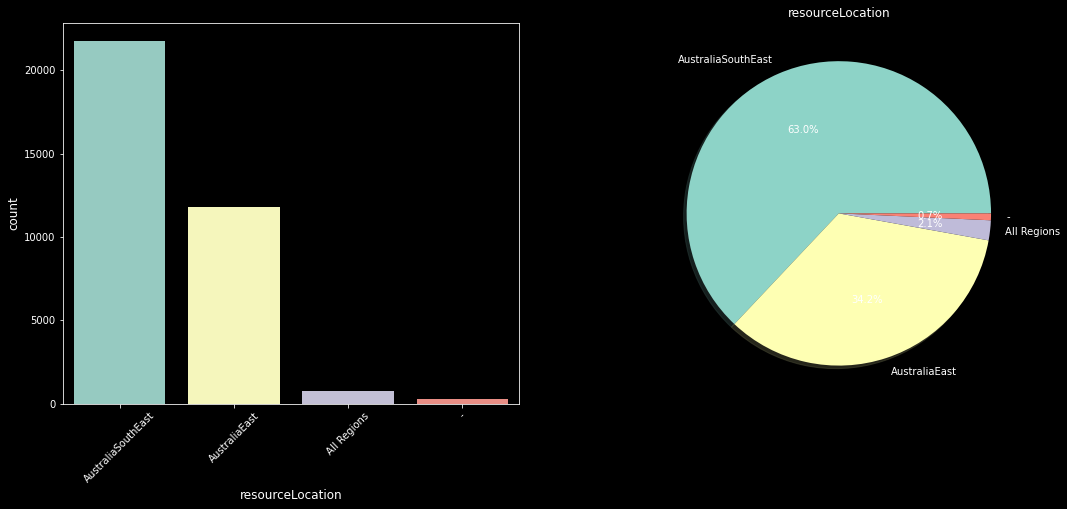

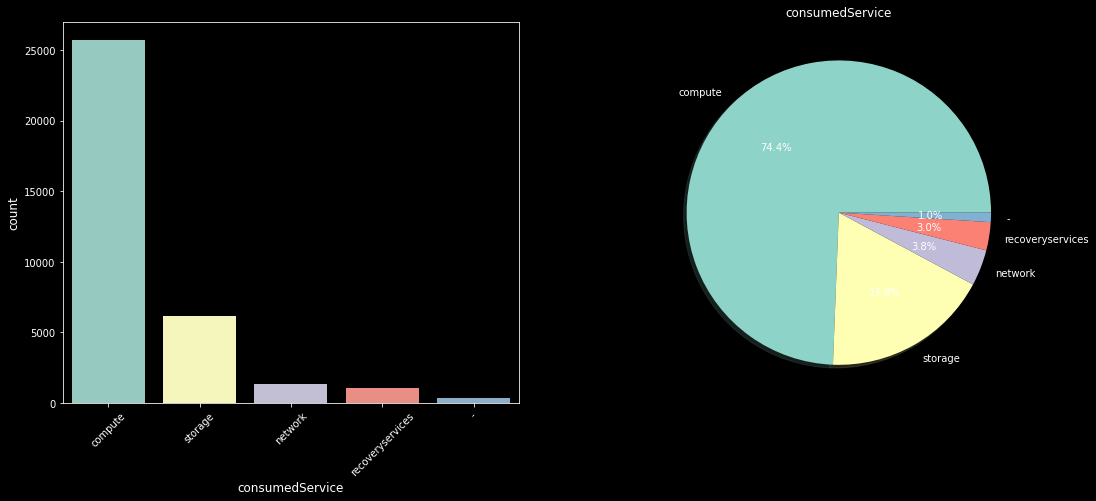

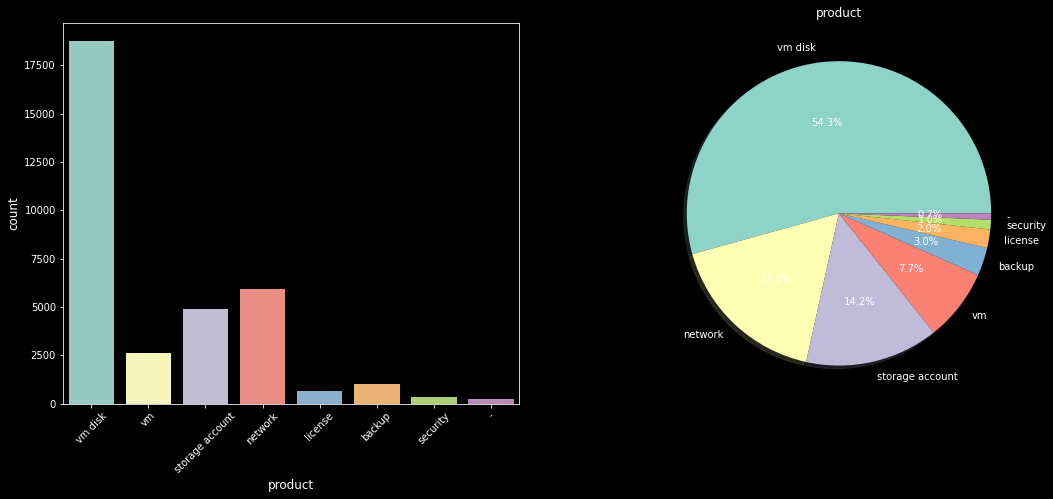

In [16]:
for col in col_cat:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.countplot(x=df[col], ax=ax[0], hue=df[y_label] if CLASSIFICATION else None).set_xlabel(f"{col}")
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
    ax[1].pie(x=df[col].value_counts(), autopct="%.1f%%", shadow=True, labels=df[col].value_counts().index)
    ax[1].set_title(col)
plt.show()

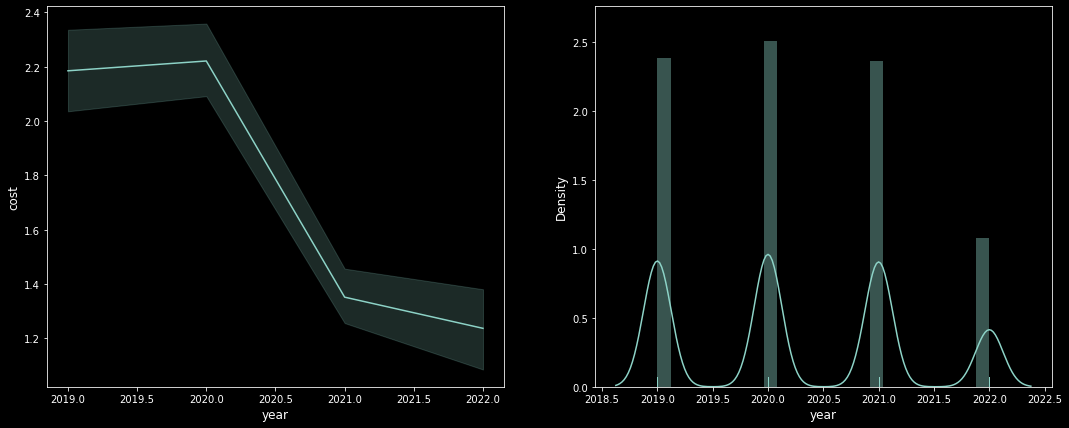

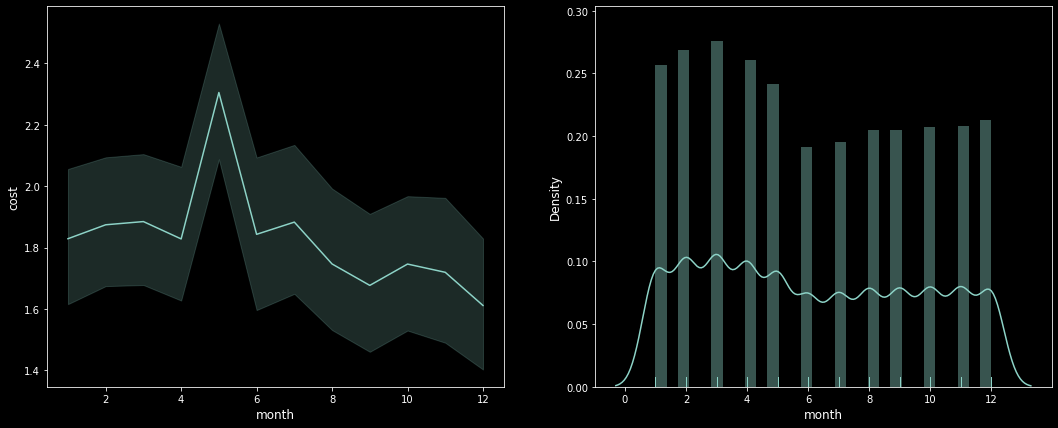

In [17]:
for col in col_num_disc + ([y_label] if CLASSIFICATION else []):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.lineplot(x=df[col], y=df[y_label], ax=ax[0]).set_xlabel(f"{col}")
    sns.distplot(x=df[col], ax=ax[1], rug=True).set_xlabel(f"{col}")
plt.show()

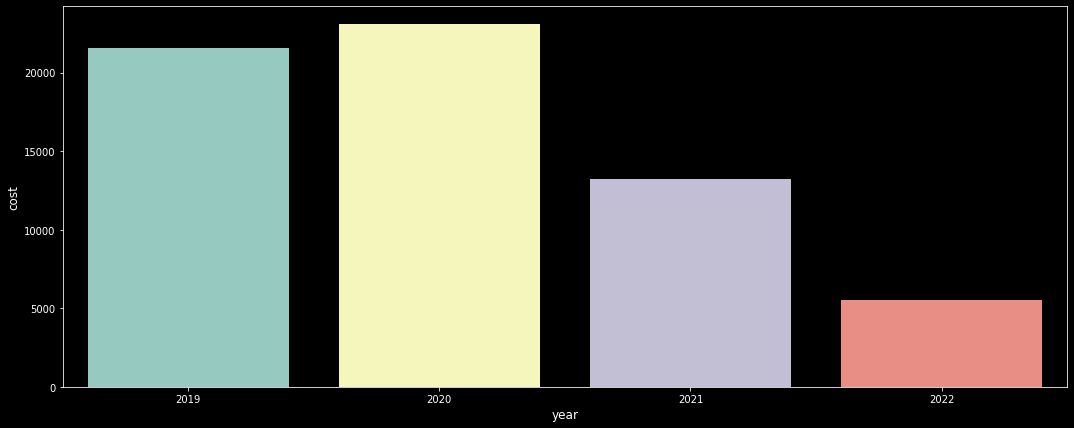

In [18]:
df_product_cost = df.groupby("year")["cost"].sum().to_frame().reset_index()
sns.barplot(x="year", y="cost", hue=None, data=df_product_cost)
plt.show()

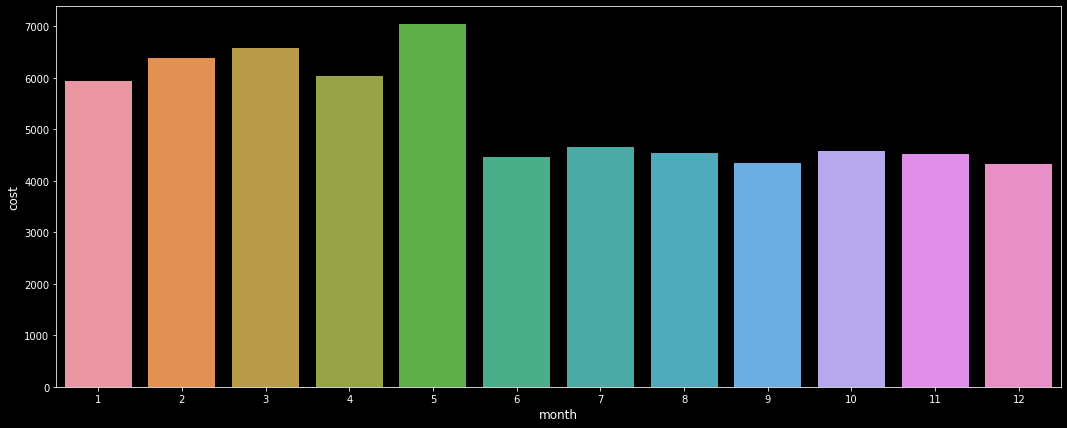

In [19]:
df_product_cost = df.groupby("month")["cost"].sum().to_frame().reset_index()
sns.barplot(x="month", y="cost", hue=None, data=df_product_cost)
plt.show()

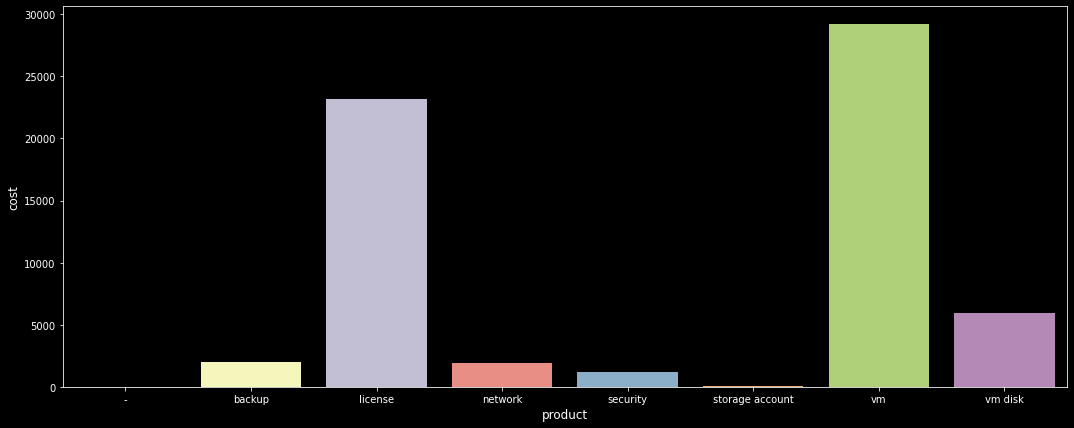

In [20]:
df_product_cost = df.groupby("product")["cost"].sum().to_frame().reset_index()
sns.barplot(x="product", y="cost", hue=None, data=df_product_cost)
plt.show()

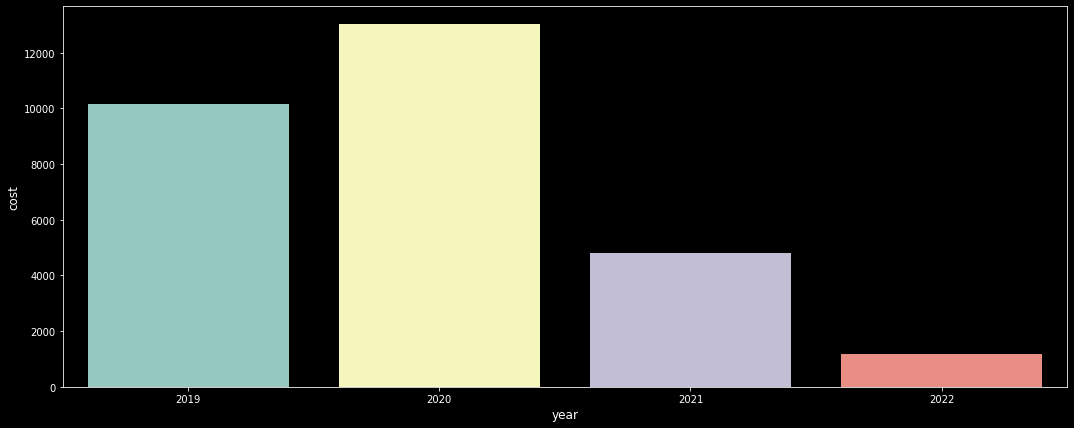

In [21]:
df_product_cost = df[df["product"] == "vm"].groupby("year")["cost"].sum().to_frame().reset_index()
sns.barplot(x="year", y="cost", hue=None, data=df_product_cost)
plt.show()

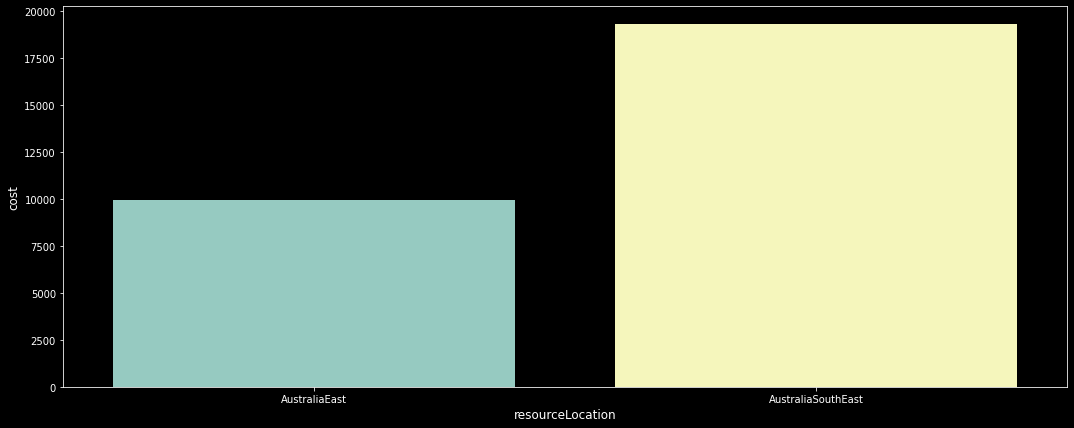

In [22]:
df_product_cost = df[df["product"] == "vm"].groupby("resourceLocation")["cost"].sum().to_frame().reset_index()
sns.barplot(x="resourceLocation", y="cost", hue=None, data=df_product_cost)
plt.show()

In [23]:
transformation_table = {
    "log": [],
    "log1p": [],
    "reciprocal": [],
    "sqrt": [],
    "exp": [],
    "boxcox": [],
    "boxcox1": [],
    "cap": [],
    "drop": [],
    "keep": df.columns.tolist(),
}
for transform, cols in transformation_table.items():
    if cols:
        col_outlier = [col for col in col_num_cont + ([] if CLASSIFICATION else [y_label]) if col in cols]
        q1, q3 = df[col_outlier].quantile(0.25), df[col_outlier].quantile(0.75)
        iqr = q3 - q1
        lower_range, upper_range = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
        condition = ~((df[col_outlier] < lower_range) | (df[col_outlier] > upper_range)).any(axis=1)
        print("-------------------------------------------------------")
        print(f"Performing {transform} transformation on cols {cols}.")
        print(f"Current Shape: {df.shape}.")
        print("-------------------------------------------------------")
        print(f"Scanning for outliers in {col_outlier}.")
        print(f"Outliers Percentage: {(df.shape[0] - df[condition].shape[0]) / df.shape[0] * 100:.2f}%")
        print("-------------------------------------------------------")
        print(f"upper_range:\n{upper_range}")
        print("-------------------------------------------------------")
        print(f"lower_range:\n{lower_range}")
        print("-------------------------------------------------------")
        if transform == "keep":
            print(f"Outliers have been kept {df.shape}.")
        elif transform == "cap":
            for col in col_outlier:
                df[col] = np.where(df[col] < lower_range[col], lower_range[col], df[col])
                df[col] = np.where(df[col] > upper_range[col], upper_range[col], df[col])
            print(f"Outliers have been capped {df.shape}.")
        elif transform == "drop":
            df = df[condition]
            print(f"Outliers have been removed {df.shape}.")
        elif transform == "log":
            for col in col_outlier:
                df[col] = np.log(df[col])
            print(f"Outliers have been log transformed {df.shape}.")
        elif transform == "log1p":
            for col in col_outlier:
                df[col] = np.log1p(df[col])
            print(f"Outliers have been log1p transformed {df.shape}.")
        elif transform == "reciprocal":
            for col in col_outlier:
                df[col] = (1 / df[col])
            print(f"Outliers have been reciprocal transformed {df.shape}.")
        elif transform == "sqrt":
            for col in col_outlier:
                df[col] = (df[col] ** 0.5)
            print(f"Outliers have been sqrt transformed {df.shape}.")
        elif transform == "exp":
            for col in col_outlier:
                df[col] = (df[col] ** (1/1.2))
            print(f"Outliers have been exp transformed {df.shape}.")
        elif transform == "boxcox":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col])[0]
            print(f"Outliers have been boxcox transformed {df.shape}.")
        elif transform == "boxcox1":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col] + 1)[0]
            print(f"Outliers have been boxcox1 transformed {df.shape}.")
        print("\n\n")

-------------------------------------------------------
Performing keep transformation on cols ['date', 'year', 'month', 'cost', 'resourceLocation', 'consumedService', 'product'].
Current Shape: (34520, 7).
-------------------------------------------------------
Scanning for outliers in ['cost'].
Outliers Percentage: 16.54%
-------------------------------------------------------
upper_range:
cost   1.03
dtype: float64
-------------------------------------------------------
lower_range:
cost   -0.62
dtype: float64
-------------------------------------------------------
Outliers have been kept (34520, 7).





-------------------------------------------------------
cost
Skew: 5.36
Kurtosis: 31.73


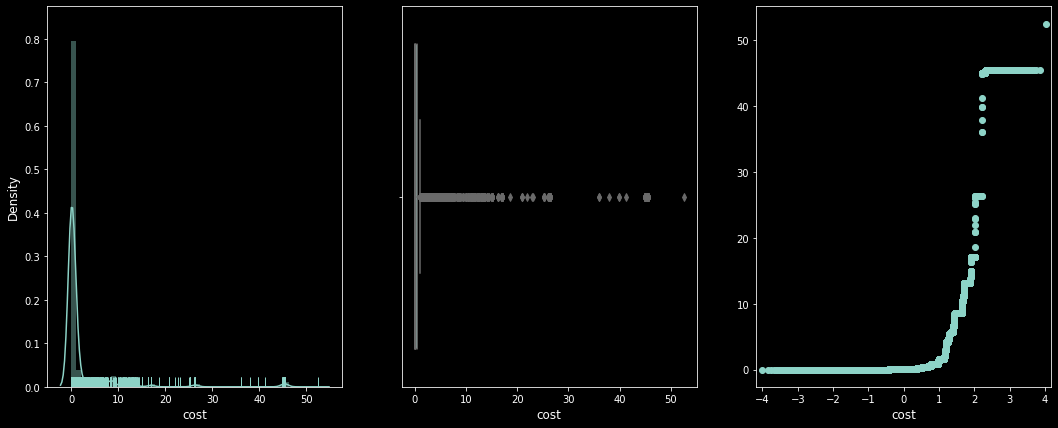

In [24]:
for col in col_num_cont + ([] if CLASSIFICATION else [y_label]):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.distplot(x=df[col], ax=ax[0], rug=True).set_xlabel(f"{col}")
    sns.boxplot(x=df[col], ax=ax[1], notch=True).set_xlabel(f"{col}")
    sm.qqplot(data=df[col], ax=ax[2], xlabel=col, ylabel="")
    print("-------------------------------------------------------")
    print(f"{col}\nSkew: {df[col].skew(axis=0, skipna=True):.2f}\nKurtosis: {df[col].kurtosis(axis=0, skipna=True):.2f}")
    plt.show()

-------------------------------------------------------
cost Keep Transformation
Skew: 5.36
Kurtosis: 31.73


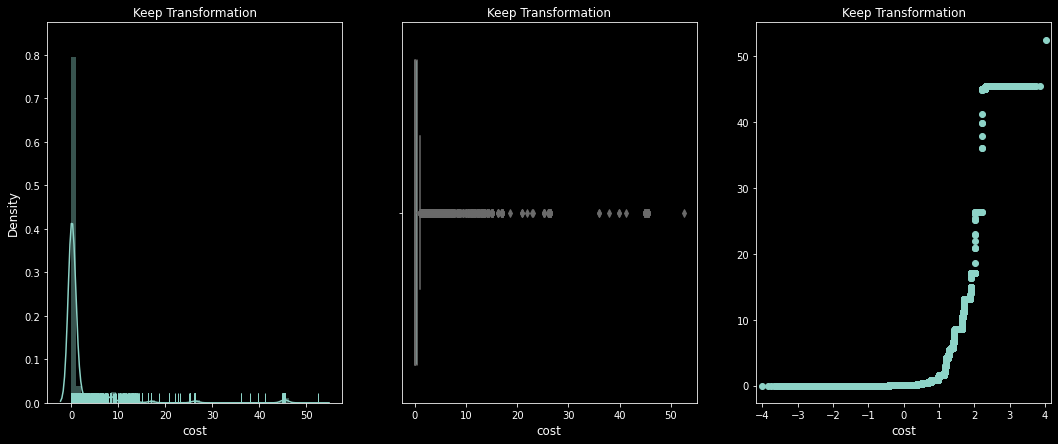

-------------------------------------------------------
cost Log Transformation
Skew: nan
Kurtosis: nan


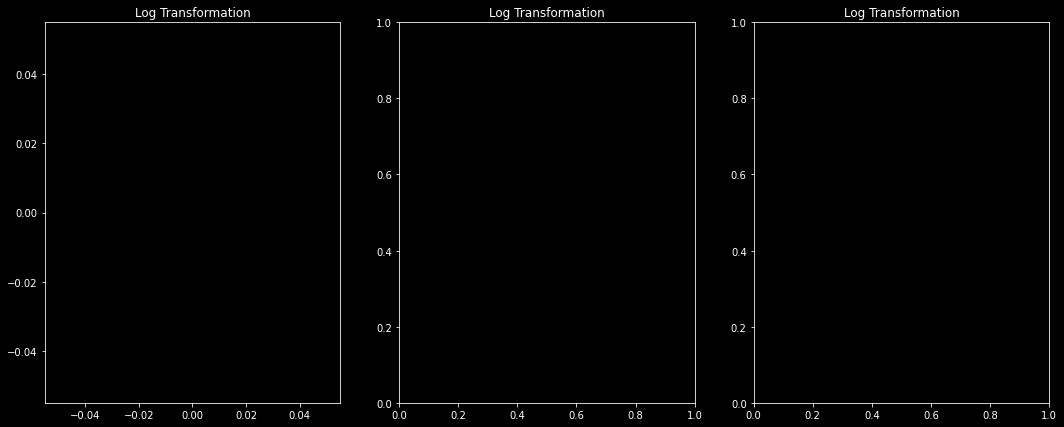

-------------------------------------------------------
cost Log1P Transformation
Skew: 2.41
Kurtosis: 5.24


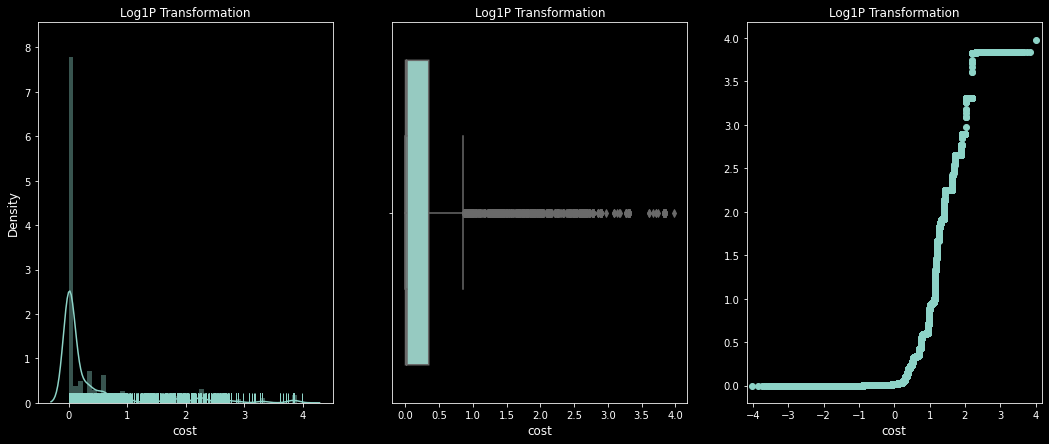

-------------------------------------------------------
cost Reciprocal Transformation
Skew: nan
Kurtosis: nan


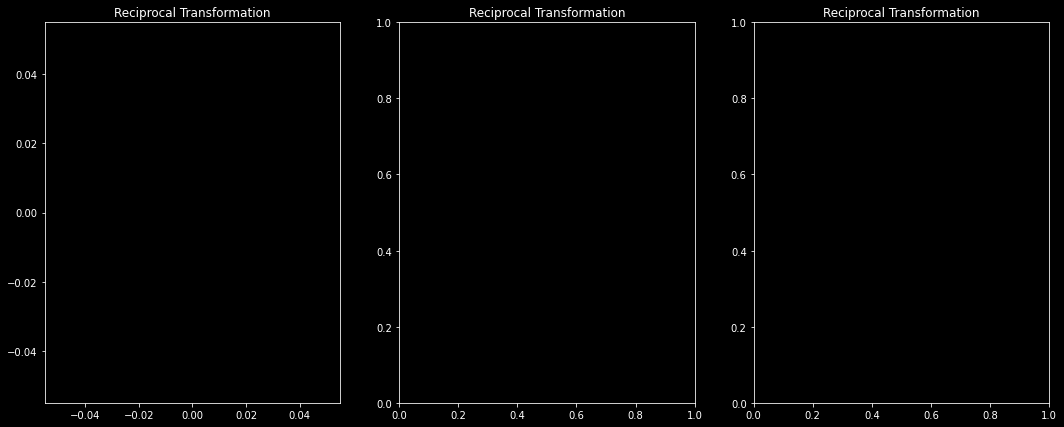

-------------------------------------------------------
cost Sqrt Transformation
Skew: 2.95
Kurtosis: 9.73


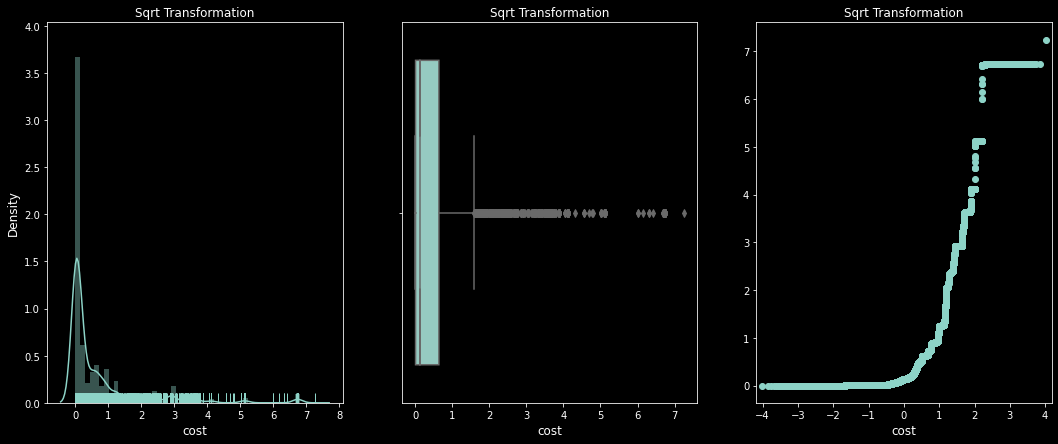

-------------------------------------------------------
cost Exp Transformation
Skew: 4.65
Kurtosis: 24.42


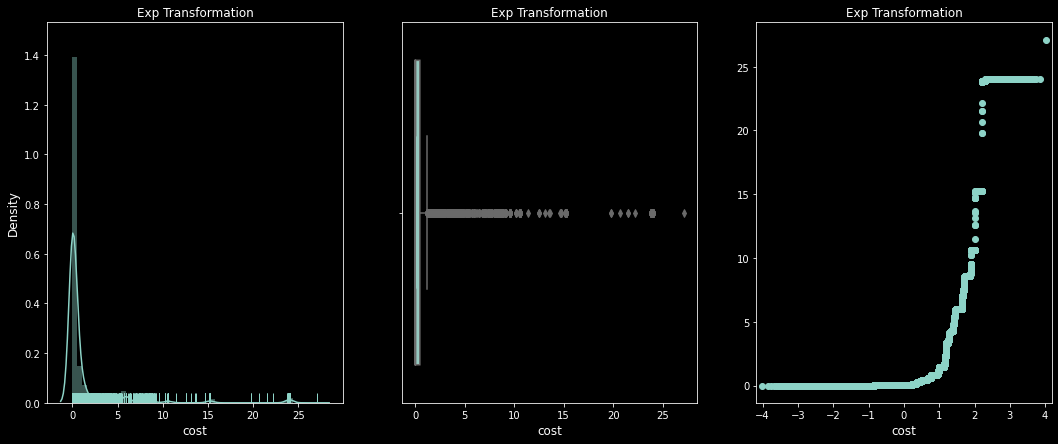

-------------------------------------------------------
cost Boxcox Transformation
Skew: 4.65
Kurtosis: 24.42


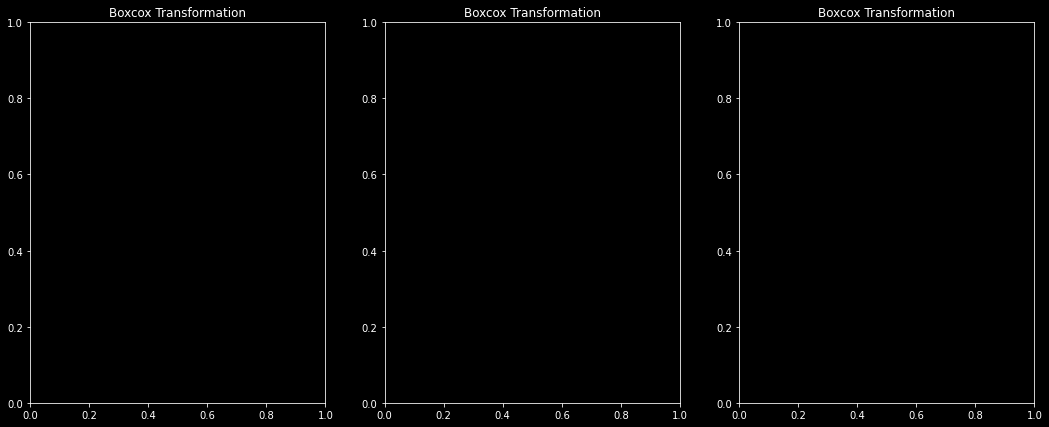

-------------------------------------------------------
cost Boxcox1 Transformation
Skew: 1.02
Kurtosis: -0.57


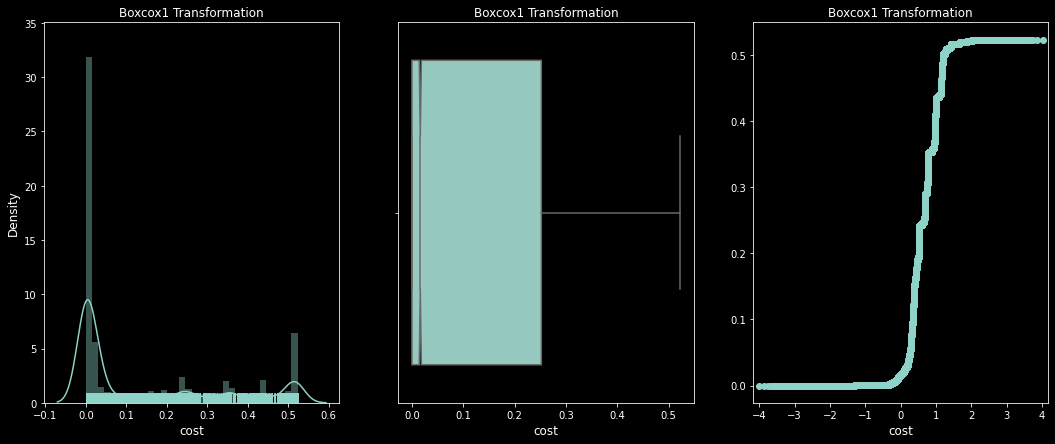

In [25]:
for col in col_num_cont + ([] if CLASSIFICATION else [y_label]):
    for trans in ["keep", "log", "log1p", "reciprocal", "sqrt", "exp", "boxcox", "boxcox1"]:
        try:
            fig, ax = plt.subplots(nrows=1, ncols=3)
            if trans == "keep":
                x = df[col]
            elif trans == "log":
                x = np.log(df[col])
            elif trans == "log1p":
                x = np.log1p(df[col])
            elif trans == "reciprocal":
                x=(1 / df[col])
            elif trans == "sqrt":
                x=(df[col] ** 0.5)
            elif trans == "exp":
                x=(df[col] ** (1/1.2))
            elif trans == "boxcox":
                x=pd.Series(stat.boxcox(df[col])[0], name=col)
            else:
                x=pd.Series(stat.boxcox(df[col] + 1)[0], name=col)
            sns.distplot(x=x, ax=ax[0], rug=True).set_xlabel(f"{col}")
            sns.boxplot(x=x, ax=ax[1], notch=True).set_xlabel(f"{col}")
            sm.qqplot(data=x, ax=ax[2], xlabel=col, ylabel="")
        except Exception:
            pass
        finally:
            for i in range(3):
                ax[i].set_title(f"{trans.title()} Transformation")
            print("-------------------------------------------------------")
            print(f"{col} {trans.title()} Transformation\nSkew: {x.skew(axis=0, skipna=True):.2f}\nKurtosis: {x.kurtosis(axis=0, skipna=True):.2f}")
            plt.show()

In [26]:
if col_num_cont:
    plt.title("Boxplots for Numeric Columns")
    sns.boxplot(data=df[[col for col in col_num_cont]], orient="h", notch=True)
    plt.show()

In [27]:
display(df.describe().T.style.background_gradient(cmap="Blues").format("{:.2f}"))
display(df.quantile([0.01, 0.99]).T.style.background_gradient(cmap="Blues").format("{:.2f}"))

,count,mean,std,min,25%,50%,75%,max
year,34520.00,2020.26,1.01,2019.00,2019.00,2020.00,2021.00,2022.00
month,34520.00,6.15,3.50,1.00,3.00,6.00,9.00,12.00
cost,34520.00,1.84,6.25,0.00,0.00,0.02,0.41,52.50


,0.01,0.99
year,2019.00,2022.00
month,1.00,12.00
cost,0.00,45.42


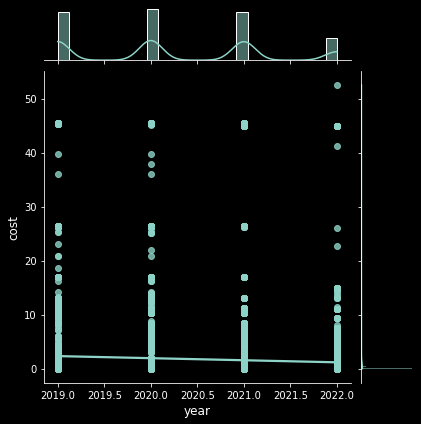

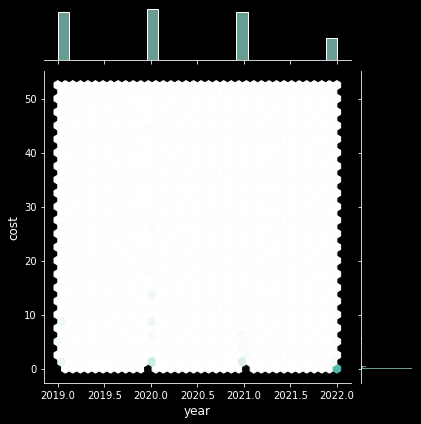

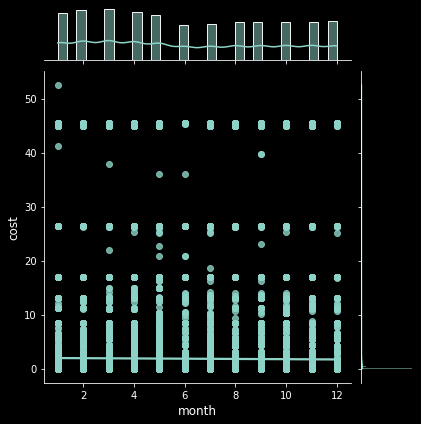

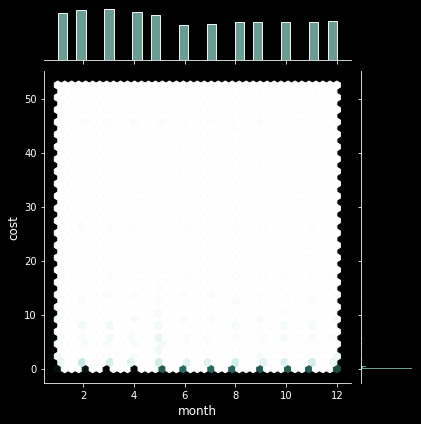

In [28]:
for col in col_num:
    if CLASSIFICATION:
        fig, ax = plt.subplots(nrows=1, ncols=1)
        sns.swarmplot(x=y_label, y=col, data=df, color="grey", alpha=0.7, ax=ax)
        sns.boxenplot(x=y_label, y=col, data=df, ax=ax)
    else:
        sns.jointplot(x=col, y=y_label, hue=None, data=df, kind="reg")
        sns.jointplot(x=col, y=y_label, hue=None, data=df, kind="hex")
    plt.show()

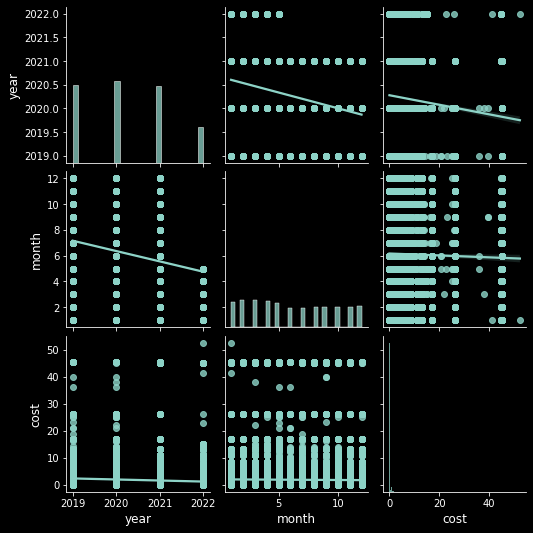

In [29]:
sns.pairplot(df, hue=y_label if CLASSIFICATION else None, kind="reg")

Target looks like regression


[array([[<AxesSubplot:title={'center':'F=6.03E+00'}, xlabel='month', ylabel='cost'>]],
       dtype=object),
 array([[<AxesSubplot:title={'center':'F=1.05E+00'}, xlabel='cost', ylabel='year'>,
         <AxesSubplot:title={'center':'F=6.45E-01'}, xlabel='cost', ylabel='resourceLocation'>,
         <AxesSubplot:title={'center':'F=6.06E-01'}, xlabel='cost', ylabel='consumedService'>,
         <AxesSubplot:title={'center':'F=3.24E-01'}, xlabel='cost', ylabel='product'>]],
       dtype=object)]

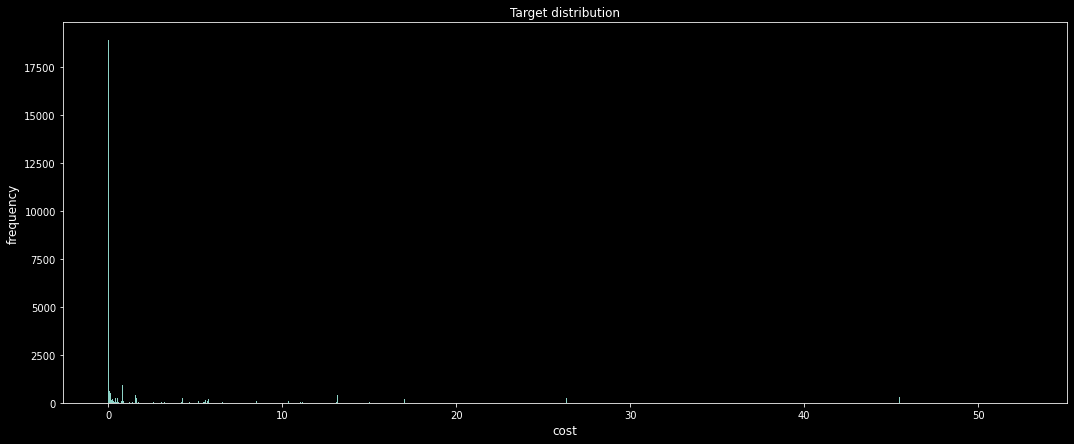

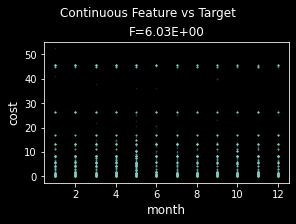

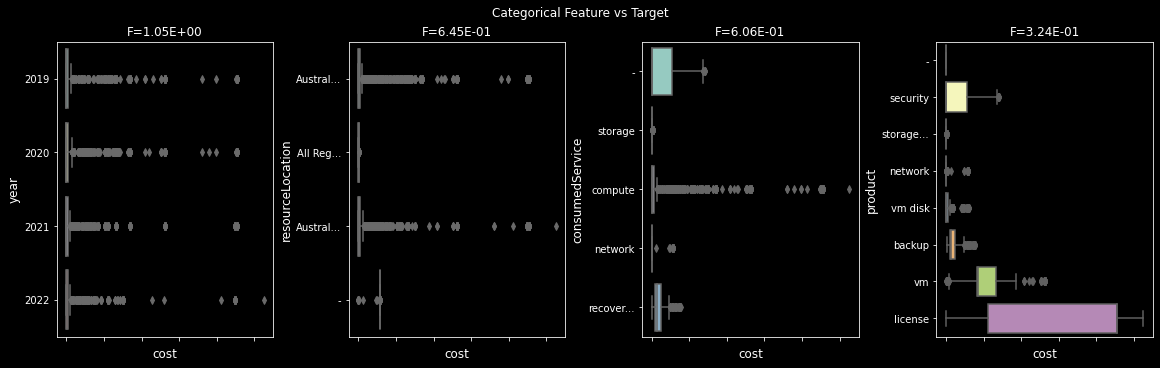

In [30]:
plot(df.drop(y_label, axis=1), df[y_label])

In [31]:
df.set_index("date", inplace=True)

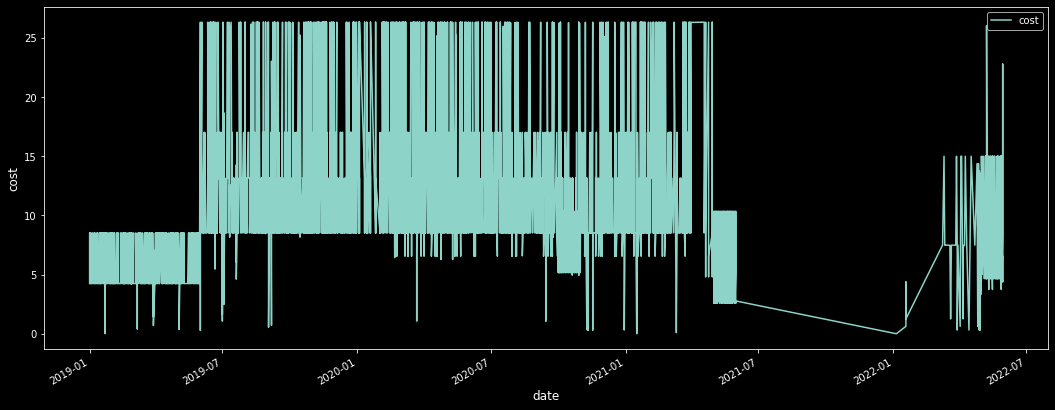

In [32]:
df = df[df["product"] == "vm"]
df.plot(y=y_label, subplots=True)
plt.xlabel("date")
plt.ylabel(y_label)
plt.show()

In [33]:
df = df[["year", "cost"]]

In [34]:
print(df.index.min(), df.index.max(), df.shape)
date_split = "2021-03-01"
df_train = df[df.index < date_split][[y_label]]
df_test = df[df.index >= date_split][[y_label]]
df_train.shape, df_test.shape

2019-01-01 00:00:00 2022-05-30 00:00:00 (2645, 2)


((2117, 1), (528, 1))

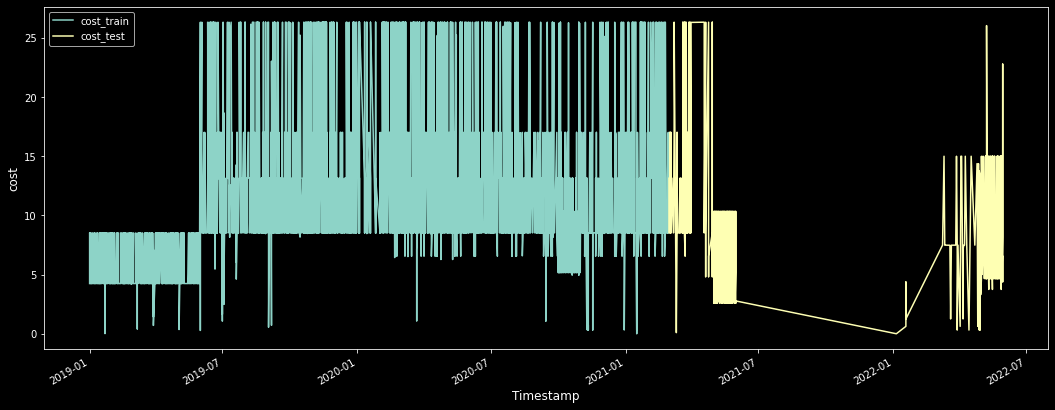

In [35]:
df_train.join(df_test, how="outer", lsuffix="_train", rsuffix="_test").plot()
plt.xlabel("Timestamp")
plt.ylabel(y_label)
plt.show()

In [36]:
transformer_cat = make_pipeline(
    (OneHotEncoder(handle_unknown="ignore")),
)
transformer_num = make_pipeline(
    (KNNImputer()),
    (MinMaxScaler()),
    (
        FunctionTransformer(
            lambda d: np.array(
                [
                    n
                    for n in zip(
                        d[:, 0], d[:, 0][1:], d[:, 0][2:], d[:, 0][3:], d[:, 0][4:]
                    )
                ]
            )
        )
    ),
)
preprocessor = make_column_transformer(
    (transformer_num, [y_label]),
)
preprocessed_train_data = preprocessor.fit_transform(df_train)
preprocessed_test_data = preprocessor.transform(df_test)
preprocessed_train_data.shape, preprocessed_test_data.shape

((2113, 5), (524, 5))

In [37]:
X_train, y_train = preprocessed_train_data[:, :-1], preprocessed_train_data[:, -1]
X_test, y_test = preprocessed_test_data[:, :-1], preprocessed_test_data[:, -1]
tests = [
    {
        "model": make_pipeline(
            (SVR()),
        ),
        "params": {
            "svr__kernel": ["rbf"],
            "svr__gamma": [0.5],
            "svr__C": [10],
            "svr__epsilon": [0.05],
        },
    },
]
for test in tests:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
    rscv = RandomizedSearchCV(
        estimator=test["model"],
        param_distributions=test["params"],
        n_jobs=-1,
        scoring="r2",
        n_iter=10,
        return_train_score=True,
    )
    rscv.fit(X_train, y_train)
    print("===train============================")
    print(f"{rscv.best_score_ * 100:.2f}%\t{test['model'][0]}\t{rscv.best_params_}")
    print("===params============================")
    display(pd.DataFrame(rscv.cv_results_).sort_values(by="rank_test_score"))
    print("===test============================")
    print(f"test score:{rscv.score(X_test, y_test) * 100:.2f}%")
    print("====end===========================\n")
rscv.best_estimator_

===train============================
-18.66%	SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)	{'svr__kernel': 'rbf', 'svr__gamma': 0.5, 'svr__epsilon': 0.05, 'svr__C': 10}
===params============================


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__kernel,param_svr__gamma,param_svr__epsilon,param_svr__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.43,0.03,0.06,0.02,rbf,0.50,0.05,10,"{'svr__kernel': 'rbf', 'svr__gamma': 0.5, 'svr...",-0.41,-0.17,-0.22,-0.11,-0.03,-0.19,0.13,1,-0.04,0.14,0.15,0.13,0.16,0.11,0.07


===test============================
test score:12.94%
====end===========================



Pipeline(memory=None,
         steps=[('svr',
                 SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05,
                     gamma=0.5, kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

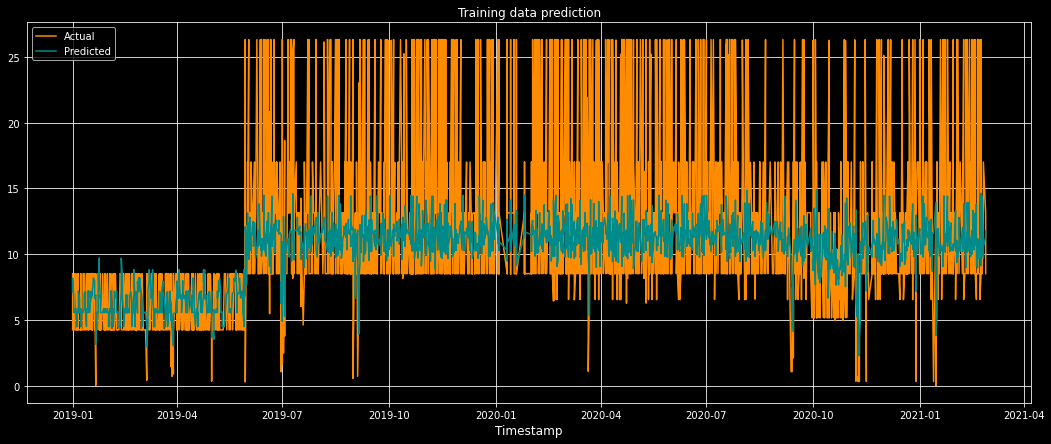

In [38]:
plt.plot(
    df_train.index[:-4],
    preprocessor.named_transformers_["pipeline"]
    .named_steps["minmaxscaler"]
    .inverse_transform(y_train.reshape(-1, 1))[: np.newaxis],
    color="darkorange",
)
plt.plot(
    df_train.index[:-4],
    preprocessor.named_transformers_["pipeline"]
    .named_steps["minmaxscaler"]
    .inverse_transform(rscv.predict(X_train).reshape(-1, 1))[: np.newaxis],
    color="darkcyan",
)
plt.legend(["Actual", "Predicted"])
plt.xlabel("Timestamp")
plt.title("Training data prediction")
plt.grid()
plt.show()

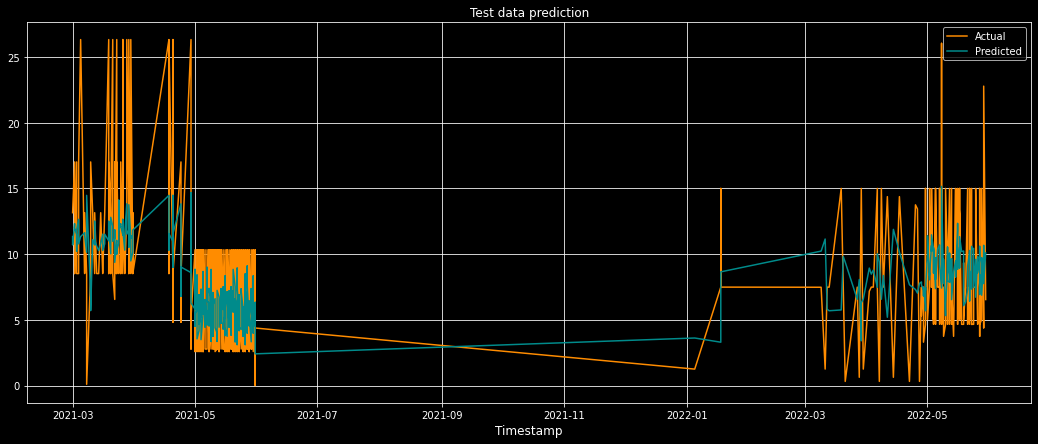

In [39]:
plt.plot(
    df_test.index[:-4],
    preprocessor.named_transformers_["pipeline"]
    .named_steps["minmaxscaler"]
    .inverse_transform(y_test.reshape(-1, 1))[: np.newaxis],
    color="darkorange",
)
plt.plot(
    df_test.index[:-4],
    preprocessor.named_transformers_["pipeline"]
    .named_steps["minmaxscaler"]
    .inverse_transform(rscv.predict(X_test).reshape(-1, 1))[: np.newaxis],
    color="darkcyan",
)
plt.legend(["Actual", "Predicted"])
plt.xlabel("Timestamp")
plt.title("Test data prediction")
plt.grid()
plt.show()

In [ ]:
import pandas as pd
import requests

df_old = pd.read_csv("vmaudit_old.csv")
df = pd.read_csv("vmaudit.csv")
df.drop_duplicates(inplace=True)
df.drop(
    [
        "TYPE",
        "RESOURCE GROUP",
        "PUBLIC IP ADDRESS",
        "DISKS",
        "KIND",
        "RESOURCE TYPE",
        "Unnamed: 17",
    ],
    axis=1,
    inplace=True,
)
df = df[df["OPERATING SYSTEM"] == "Windows"]
df.columns = [col.title() for col in df.columns]
df.replace(
    {"Australia Southeast": "Melbourne", "Australia East": "Sydney"}, inplace=True
)
df["Size"] = df["Size"].str.lower()
for size in df["Size"].unique():
    if size.lower() not in list(df_old["SIZE"].unique()):
        print(size)
print(df["Size"].nunique(), df_old["SIZE"].nunique())
df = pd.merge(left=df, right=df_old, left_on="Size", right_on="SIZE", how="left")
df["Equal_Size"] = df.apply(lambda r: r["Size"] == r["SIZE"], axis=1)
df["CORES"] = df["CORES"].astype(int)
df = df[
    [
        "Name",
        "Subscription",
        "Location",
        "Status",
        "Operating System",
        "Size",
        "vCores",
        "Os Licensing Benefit",
        "Source",
        "Publisher",
        "Offer",
        "Plan",
    ]
]
df.rename({"CORES": "vCores"}, axis=1, inplace=True)
df_mg = pd.json_normalize(
    requests.post(
        "https://management.azure.com/providers/Microsoft.Management/getEntities?api-version=2020-05-01",
        headers=rest_api_headers,
    ).json()["value"]
)
df_mg = df_mg[df_mg["type"] == "/subscriptions"]
df_mg["mg0"] = df_mg["properties.parentDisplayNameChain"].str.get(-1)
df_mg[["Management", "mg2", "Department", "mg4"]] = (
    df_mg["mg0"].astype(str).str.split("_", expand=True)
)
df_mg = df_mg[df_mg["Management"].isin(["Cenitex", "Customer", "Tier"])]
df_mg["Department"].replace({np.nan: "Cenitex", "Dev": "Cenitex"}, inplace=True)
df_mg["Management"].replace(
    {"Cenitex": "Cenitex Managed", "Customer": "Customer Managed", "Tier": "T0"},
    inplace=True,
)
df_mg = df_mg[["properties.displayName", "Management", "Department"]]
df_mg.columns = ["subscriptionName", "management", "department"]
df = pd.merge(
    left=df,
    right=df_mg,
    left_on="Subscription",
    right_on="subscriptionName",
    how="left",
)
df = df[
    [
        "Name",
        "Subscription",
        "management",
        "department",
        "Location",
        "Status",
        "Operating System",
        "Size",
        "vCores",
        "Os Licensing Benefit",
        "Source",
        "Publisher",
        "Offer",
        "Plan",
    ]
]